In [1]:
# import the usual
# import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
import numpy as np
# import hashlib
import datetime
#import surprise
#from surprise import SVD
%matplotlib inline
pd.set_option('display.max_columns', 500)

import sys
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random

from sklearn.preprocessing import MinMaxScaler

import implicit # The Cython library


In [2]:
## create function to recommend using ALS for user_id
def ALS_recommend_for_user(model_given, user_id, sparse_user_item_field, N , orig_df ): #will add moe parameters later
    #user_id = 150
    ##### can be used for any model
    # Use the implicit recommender.
    #recommended = model.recommend(user_id, sparse_user_item, N, filter_already_liked_items = False)
    # got zero
    
    recommended = model_given.recommend(user_id, sparse_user_item_field, N )
    
    songs = []
    scores = []
    song_id_new_list = []
    
    # Get artist names from ids
    for item in recommended:
        idx, score = item
        #songs.append(user_song_df_count.song.loc[user_song_df_count.song_id_new == idx].iloc[0])
        #orig_df
        songs.append(user_song_df_count.song.loc[orig_df.song_id_new == idx].iloc[0])
        scores.append(score)
        #song_id_new_list.append(idx) #idx is not what it seems

    # Create a dataframe of artist names and scores
    recommendations = pd.DataFrame({'Song': songs, 'score': scores})
    #recommendations = pd.DataFrame({'Song': songs, 'song_id_new': song_id_new_list, 'score': scores})

    #print ("Top ", N, "recommendations for user_id:", user_id)
    return (recommendations)

In [3]:
import random

def make_train(ratings, pct_test = 0.2):
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of item,user index into list

    
    random.seed(0) # Set the random seed to zero for reproducibility
    
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of item-user pairs without replacement

    item_inds = [index[0] for index in samples] # Get the item row indices

    user_inds = [index[1] for index in samples] # Get the user column indices

    
    training_set[item_inds, user_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user columns that were altered

In [4]:
from sklearn import metrics
import matplotlib.pylab as plt
def auc_score(predictions, test):
    '''   
    returns: - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr) 

def calc_mean_auc(training_set, altered_users, predictions, test_set):
        
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 1)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_column = training_set[:,user].toarray().reshape(-1) # Get the training set column
        zero_inds = np.where(training_column == 0) # Find where the interaction had not yet occurred
        
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[:,user].toarray()[zero_inds,0].reshape(-1)
        
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark



## Read slot data here for user_song_df_count

In [28]:
slot1 = pd.read_csv(r"F:\Data_Repository\lastfm\df_slot1.tsv", sep="\t", error_bad_lines=False, header = None)
slot2 = pd.read_csv(r"F:\Data_Repository\lastfm\df_slot2.tsv", sep="\t", error_bad_lines=False, header = None)
slot3 = pd.read_csv(r"F:\Data_Repository\lastfm\df_slot3.tsv", sep="\t", error_bad_lines=False, header = None)
slot4 = pd.read_csv(r"F:\Data_Repository\lastfm\df_slot4.tsv", sep="\t", error_bad_lines=False, header = None)

In [29]:
slots = [slot1, slot2, slot3, slot4]
#loop through the slots

In [30]:
slotid = 1
for user_song_df_count in slots:
    print ("*** Slot no. = ", slotid)
    user_song_df_count.columns = ['userid', 'song', 'count']
    # Convert userid and song names into numerical IDs
    user_song_df_count['user_id'] = user_song_df_count['userid'].astype("category").cat.codes
    user_song_df_count['song_id_new'] = user_song_df_count['song'].astype("category").cat.codes

    # Create a lookup frame so we can get the artist names back in 
    # readable form later.
    item_lookup = user_song_df_count[['song_id_new', 'song']].drop_duplicates()
    item_lookup['song_id_new'] = item_lookup.song_id_new.astype(str)

    user_song_df = user_song_df_count.drop( ['userid', 'song'], axis = 1)

    M = 20000000 #slice of df

    altered_songid_new_list = user_song_df.loc[user_song_df[:M].groupby('user_id')['song_id_new'].head(1).index, 'song_id_new']
    user_song_df.loc[user_song_df[:M].groupby('user_id')['count'].head(1).index, 'count'] = np.NaN
    altered_user_id_list = user_song_df.loc[user_song_df[:M].groupby('user_id')['user_id'].head(1).index, 'user_id']

    altered_user_id_list = altered_user_id_list.reset_index(drop = True) 
    altered_songid_new_list = altered_songid_new_list.reset_index(drop = True) 
    print (len(altered_songid_new_list), "users changed" )
    user_song_df = user_song_df.dropna()     #drop all rows that have any NaN values
    #
    # Create lists of all users, songs and counts
    users = list(np.sort(user_song_df.user_id.unique()))
    songs = list(np.sort(user_song_df.song_id_new.unique()))
    counts = list(user_song_df['count'])


    sparse_item_user = sparse.csr_matrix((user_song_df['count'].astype(float), 
                                          (user_song_df['song_id_new'], user_song_df['user_id'])))

    sparse_user_item = sparse.csr_matrix((user_song_df['count'].astype(float), 
                                          (user_song_df['user_id'], user_song_df['song_id_new'])))
    
    topn = 50
    
    ##ALS IMPLICIT
    print("")
    print ("###ALS IMPLICIT model")
    # Initialize the als model and fit it using the sparse item-user matrix
    model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

    # Calculate the confidence by multiplying it by our alpha value.
    alpha_val = 15
    data_conf = (sparse_item_user * alpha_val).astype('double')

    model.fit(data_conf)

    altered_songid_new_list = altered_songid_new_list.reset_index(drop = True) 


    cnt_total = []
    index1 = 0

    for idx in altered_user_id_list[:200]:
        #print(index1)
        recommendation_ans = ALS_recommend_for_user(model, idx, sparse_user_item, topn, user_song_df_count)
        
        ans = pd.Series(recommendation_ans['Song'].isin(                   
            user_song_df_count [user_song_df_count['user_id']== idx ] ['song']).values.astype(int),
                        recommendation_ans['Song'].values)==1
        
        cnt = 0
        for i in ans:
            if i == True:
                cnt += 1 #increment if found true
        cnt_total.append ( cnt ) #append to total found
        index1 += 1

    N = len(recommendation_ans) #what N was set as, no. of items we recommended
    precision = []

    for i in range(len(cnt_total)): #loop 0 to N-1
        precision.append( cnt_total[i] / N )

    print("Precision at rank ", N)
    #precision
    print ( sum(precision) / len(precision) )

    ###Bayesian personalised ranking
    print("")
    print ( "####Bayesian Personalised Ranking model")

    modelBayesian = implicit.bpr.BayesianPersonalizedRanking(factors=20, regularization=0.1, iterations=20)
    # Calculate the confidence by multiplying it by our alpha value.
    alpha_val = 15
    data_conf = (sparse_item_user * alpha_val).astype('double')
    #fit model
    modelBayesian.fit(data_conf)
    
    
    cnt_total = []
    index1 = 0
    for idx in altered_user_id_list[:50]:
        #print(index1)
        recommendation_ans = ALS_recommend_for_user(modelBayesian, idx, sparse_user_item, topn, user_song_df_count)
        
        ans = pd.Series(recommendation_ans['Song'].isin(                   
            user_song_df_count [user_song_df_count['user_id']== idx ] ['song']).values.astype(int),
                        recommendation_ans['Song'].values)==1
        
        cnt = 0
        for i in ans:
            if i == True:
                cnt += 1 #increment if found true
        cnt_total.append ( cnt ) #append to total found
        index1 += 1

    N = len(recommendation_ans) #what N was set as, no. of items we recommended
    precision = []

    for i in range(len(cnt_total)): #loop 0 to N-1
        precision.append( cnt_total[i] / N )

    print("Precision at rank ", N)
    #precision
    print (sum(precision) / len(precision) )
    
    slotid += 1



*** Slot no. =  1
922 users changed

###ALS IMPLICIT model


100%|████████████████████████████████████████████████████████████████████████████████| 20.0/20 [00:00<00:00, 26.32it/s]


Precision at rank  50
0.0006000000000000001

####Bayesian Personalised Ranking model


100%|██████████████████████████████████████████████████| 20/20 [00:00<00:00, 49.39it/s, correct=52.45%, skipped=19.66%]


Precision at rank  50
0.0
*** Slot no. =  2
950 users changed

###ALS IMPLICIT model


100%|████████████████████████████████████████████████████████████████████████████████| 20.0/20 [00:00<00:00, 25.98it/s]


Precision at rank  50
0.0016

####Bayesian Personalised Ranking model


100%|██████████████████████████████████████████████████| 20/20 [00:00<00:00, 46.54it/s, correct=52.37%, skipped=17.38%]


Precision at rank  50
0.0008
*** Slot no. =  3
975 users changed

###ALS IMPLICIT model


100%|████████████████████████████████████████████████████████████████████████████████| 20.0/20 [00:01<00:00, 19.19it/s]


Precision at rank  50
0.0008

####Bayesian Personalised Ranking model


100%|██████████████████████████████████████████████████| 20/20 [00:00<00:00, 61.51it/s, correct=52.73%, skipped=20.15%]


Precision at rank  50
0.0
*** Slot no. =  4
973 users changed

###ALS IMPLICIT model


100%|████████████████████████████████████████████████████████████████████████████████| 20.0/20 [00:00<00:00, 30.25it/s]


Precision at rank  50
0.0005

####Bayesian Personalised Ranking model


100%|██████████████████████████████████████████████████| 20/20 [00:00<00:00, 58.81it/s, correct=52.97%, skipped=21.17%]


Precision at rank  50
0.0004


## testing for AUC

In [8]:
slot1 = pd.read_csv(r"F:\Data_Repository\lastfm\df_slot1.tsv", sep="\t", error_bad_lines=False, header = None)
slot2 = pd.read_csv(r"F:\Data_Repository\lastfm\df_slot2.tsv", sep="\t", error_bad_lines=False, header = None)
slot3 = pd.read_csv(r"F:\Data_Repository\lastfm\df_slot3.tsv", sep="\t", error_bad_lines=False, header = None)
slot4 = pd.read_csv(r"F:\Data_Repository\lastfm\df_slot4.tsv", sep="\t", error_bad_lines=False, header = None)
slots = [slot1, slot2, slot3, slot4]
#loop through the slots

In [9]:
%%time
slotid = 1
for user_song_df_count in slots:
    print ("*** Slot no. = ", slotid)
    user_song_df_count.columns = ['userid', 'song', 'count']
    # Convert userid and song names into numerical IDs
    user_song_df_count['user_id'] = user_song_df_count['userid'].astype("category").cat.codes
    user_song_df_count['song_id_new'] = user_song_df_count['song'].astype("category").cat.codes

    # Create a lookup frame so we can get the artist names back in 
    # readable form later.
    item_lookup = user_song_df_count[['song_id_new', 'song']].drop_duplicates()
    item_lookup['song_id_new'] = item_lookup.song_id_new.astype(str)

    user_song_df = user_song_df_count.drop( ['userid', 'song'], axis = 1)

    # M = 20000000 #slice of df
    # 
    # altered_songid_new_list = user_song_df.loc[user_song_df[:M].groupby('user_id')['song_id_new'].head(1).index, 'song_id_new']
    # user_song_df.loc[user_song_df[:M].groupby('user_id')['count'].head(1).index, 'count'] = np.NaN
    # altered_user_id_list = user_song_df.loc[user_song_df[:M].groupby('user_id')['user_id'].head(1).index, 'user_id']
    # 
    # altered_user_id_list = altered_user_id_list.reset_index(drop = True) 
    # altered_songid_new_list = altered_songid_new_list.reset_index(drop = True) 
    # print (len(altered_songid_new_list), "users changed" )
    # user_song_df = user_song_df.dropna()     #drop all rows that have any NaN values
    # #
    # # Create lists of all users, songs and counts
    # users = list(np.sort(user_song_df.user_id.unique()))
    # songs = list(np.sort(user_song_df.song_id_new.unique()))
    # counts = list(user_song_df['count'])


    sparse_item_user = sparse.csr_matrix((user_song_df['count'].astype(float), 
                                          (user_song_df['song_id_new'], user_song_df['user_id'])))

    sparse_user_item = sparse.csr_matrix((user_song_df['count'].astype(float), 
                                          (user_song_df['user_id'], user_song_df['song_id_new'])))

    ##ALS IMPLICIT
    print("")
    print ("###ALS IMPLICIT model")
    # Initialize the als model and fit it using the sparse item-user matrix
    product_train, product_test, product_users_altered = make_train(sparse_item_user, pct_test = 0.05)
    model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

    # Calculate the confidence by multiplying it by our alpha value.
    alpha_val = 15
    data_conf = (product_train * alpha_val).astype('double')

    model.fit(data_conf)
    item_vecs = model.item_factors
    user_vecs = model.user_factors

    print ( calc_mean_auc(product_train, product_users_altered,
                  [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], product_test) )
    # AUC for our recommender system    
    ###Bayesian personalised ranking
    print("")
    ###Bayesian personalised ranking
    print("")
    print ( "####Bayesian Personalised Ranking model")

    modelBayesian = implicit.bpr.BayesianPersonalizedRanking(factors=10, regularization=0.3, iterations=10)
    # Calculate the confidence by multiplying it by our alpha value.
    alpha_val = 30
    data_conf = (sparse_item_user * alpha_val).astype('double')
    #fit model
    modelBayesian.fit(data_conf)
    item_vecs = model.item_factors
    user_vecs = model.user_factors

    print ( calc_mean_auc(product_train, product_users_altered,
                  [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], product_test) )
    slotid += 1

*** Slot no. =  1

###ALS IMPLICIT model


100%|████████████████████████████████████████████████████████████████████████████████| 20.0/20 [00:00<00:00, 44.76it/s]


(0.743, 0.63)


####Bayesian Personalised Ranking model


100%|██████████████████████████████████████████████████| 10/10 [00:00<00:00, 91.15it/s, correct=52.60%, skipped=19.54%]


(0.743, 0.63)
*** Slot no. =  2

###ALS IMPLICIT model


100%|████████████████████████████████████████████████████████████████████████████████| 20.0/20 [00:00<00:00, 46.64it/s]


(0.76, 0.643)


####Bayesian Personalised Ranking model


100%|██████████████████████████████████████████████████| 10/10 [00:00<00:00, 86.44it/s, correct=51.92%, skipped=17.42%]


(0.76, 0.643)
*** Slot no. =  3

###ALS IMPLICIT model


100%|████████████████████████████████████████████████████████████████████████████████| 20.0/20 [00:00<00:00, 31.58it/s]


(0.764, 0.635)


####Bayesian Personalised Ranking model


100%|██████████████████████████████████████████████████| 10/10 [00:00<00:00, 62.67it/s, correct=52.39%, skipped=20.02%]


(0.764, 0.635)
*** Slot no. =  4

###ALS IMPLICIT model


100%|████████████████████████████████████████████████████████████████████████████████| 20.0/20 [00:00<00:00, 32.66it/s]


(0.766, 0.636)


####Bayesian Personalised Ranking model


100%|██████████████████████████████████████████████████| 10/10 [00:00<00:00, 62.67it/s, correct=52.33%, skipped=21.18%]


(0.766, 0.636)
Wall time: 24.7 s


In [10]:
import matplotlib.pyplot as plt

In [ ]:
ALS and Bayesian PR
AUC Curve score
Slot 1: 0.743, 0.63
Slot 2: 0.76 , 0.643
slot 3: 0.764, 0.635
slot 4: 0.766, 0.636

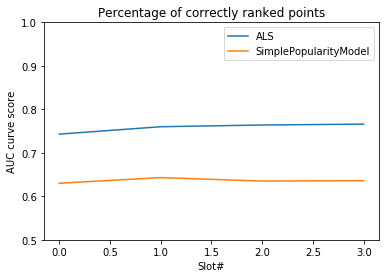

In [23]:
line, = plt.plot([0.743,0.76,0.764,0.766], label='ALS')
line, = plt.plot([0.63,0.643,0.635,0.636], label='SimplePopularityModel')
plt.ylim(0.5, 1)
plt.title('Percentage of correctly ranked points')
plt.xlabel('Slot#')
plt.ylabel('AUC curve score')
plt.legend()

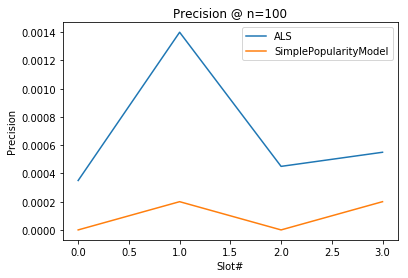

In [27]:
line, = plt.plot([0.00035000000000000005,0.0014000000000000004,0.00045,0.0005499999999999999], label='ALS')
line, = plt.plot([0,0.0002,0,0.0002], label='SimplePopularityModel')
#plt.ylim(0.5, 1)
plt.title('Precision @ n=100')
plt.xlabel('Slot#')
plt.ylabel('Precision')
plt.legend()